In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import matplotlib.pyplot as plt
import random
import os

In [2]:
class TextureDataset(Dataset):
    def __init__(self, diff_dir, disp_dir, nor_dir, rough_dir,transform=None):
        self.diff = diff_dir
        self.disp = disp_dir
        self.nor = nor_dir
        self.rough= rough_dir
        self.transform = transform
    def __len__(self):
        return len(os.listdir(self.diff))
    def __getitem__(self,idx):
        img_name = os.listdir(self.diff)[idx][:-11]
        diff_img = Image.open(self.diff+"/"+img_name+"diff_1k.jpg").convert('RGB')
        disp_img = Image.open(self.disp+"/"+img_name+"disp_1k.jpg").convert('L')
        nor_img = Image.open(self.nor+"/"+img_name+"nor_1k.jpg")
        rough_img = Image.open(self.rough+"/"+img_name+"rough_1k.jpg").convert('L')
        img_list = [diff_img, disp_img, nor_img, rough_img]
        seed = np.random.randint(2147483647)

        if self.transform is not None:
            for i, img in enumerate(img_list):
                random.seed(seed)
                torch.manual_seed(seed)
                img_list[i] = self.transform(img)

        return {"diff": img_list[0], "disp": img_list[1], "nor": img_list[2], "rough":img_list[3]}

In [3]:
data_transform = transforms.Compose([
        transforms.RandomCrop(900),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
    ])

In [4]:
diff_dir = "./Data/diff"
disp_dir = "./Data/disp"
nor_dir = "./Data/nor"
rough_dir = "./Data/rough"
dataset = TextureDataset(diff_dir, disp_dir, nor_dir, rough_dir, transform = data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle =True)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = True)

In [5]:
from resnet import ResNet

device = torch.device("cuda")

model = ResNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = nn.MSELoss().to(device)

In [ ]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    loss2 = 0
    for data in train_dataloader:
        x= data["diff"].to(device)
        y_disp= data["disp"].to(device)
        y_norm= data["nor"].to(device)
        y_rough= data["rough"].to(device)
        optimizer.zero_grad()
        out_disp, out_norm, out_rough= model(x)
        
        train_loss = (criterion(out_disp, y_disp) + criterion(out_norm, y_norm) + criterion(out_rough, y_rough))/3
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    for data in test_dataloader:
        x= data["diff"].to(device)
        y_disp= data["disp"].to(device)
        y_norm= data["nor"].to(device)
        y_rough= data["rough"].to(device)

        out_disp, out_norm, out_rough= model(x)
        test_loss = (criterion(out_disp, y_disp) + criterion(out_norm, y_norm) + criterion(out_rough, y_rough))/3
        loss2 += test_loss.item() 
        
    loss = loss / len(train_dataloader)
    loss2 = loss2 / len(test_dataloader)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, testloss = {:.6f}".format(epoch + 1, epochs, loss,loss2))

In [7]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    loss2 = 0
    for data in train_dataloader:
        x= data["diff"].to(device)
        y_disp= data["disp"].to(device)
        y_norm= data["nor"].to(device)
        y_rough= data["rough"].to(device)
        optimizer.zero_grad()
        out_norm= model(x)
        
        train_loss = criterion(out_norm, y_norm)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    for data in test_dataloader:
        x= data["diff"].to(device)
        y_disp= data["disp"].to(device)
        y_norm= data["nor"].to(device)
        y_rough= data["rough"].to(device)

        out_norm= model(x)
        test_loss = criterion(out_norm, y_norm)
        loss2 += test_loss.item() 
        
    loss = loss / len(train_dataloader)
    loss2 = loss2 / len(test_dataloader)
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, testloss = {:.6f}".format(epoch + 1, epochs, loss,loss2))

epoch : 1/20, loss = 0.294730, testloss = 0.236575
epoch : 2/20, loss = 0.198869, testloss = 0.154384
epoch : 3/20, loss = 0.116573, testloss = 0.073015
epoch : 4/20, loss = 0.051676, testloss = 0.028632
epoch : 5/20, loss = 0.019194, testloss = 0.014983
epoch : 6/20, loss = 0.014567, testloss = 0.015980
epoch : 7/20, loss = 0.013130, testloss = 0.010573
epoch : 8/20, loss = 0.010098, testloss = 0.011013
epoch : 9/20, loss = 0.008829, testloss = 0.010126
epoch : 10/20, loss = 0.007995, testloss = 0.009197
epoch : 11/20, loss = 0.007285, testloss = 0.006377
epoch : 12/20, loss = 0.006994, testloss = 0.006307
epoch : 13/20, loss = 0.006709, testloss = 0.006913
epoch : 14/20, loss = 0.006916, testloss = 0.006791
epoch : 15/20, loss = 0.006148, testloss = 0.007527
epoch : 16/20, loss = 0.006513, testloss = 0.008295
epoch : 17/20, loss = 0.006702, testloss = 0.004836
epoch : 18/20, loss = 0.006579, testloss = 0.006829
epoch : 19/20, loss = 0.006466, testloss = 0.006581
epoch : 20/20, loss =

In [8]:
import torchvision.utils as vutils
data = next(iter(test_dataloader))
diff = data["diff"]
disp = data["disp"]
norm = data["nor"]
rough = data["rough"]
out_norm= model(diff.to(device))

NameError: name 'out_rough' is not defined

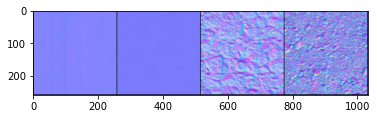

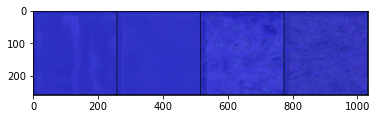

<Figure size 432x288 with 0 Axes>

In [10]:
out_img = np.transpose(vutils.make_grid(norm[0:4], normalize=True),(1,2,0))
plt.imshow(out_img)
# plt.figure()
# plt.imshow(np.transpose(vutils.make_grid(out_disp[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(out_norm[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(out_rough[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(disp[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(norm[0:4].detach().cpu(), normalize=True),(1,2,0)))
plt.figure()
plt.imshow(np.transpose(vutils.make_grid(rough[0:4].detach().cpu(), normalize=True),(1,2,0)))


In [ ]:
torch.save(model.state_dict(),"./Model/model.pt")

In [ ]:
model.load_state_dict(torch.load("./Model/model.pt"))
model.eval()

In [ ]:
img_direc =os.listdir("./other")

In [ ]:
img_name[:-4]

In [ ]:
for img_name in os.listdir("./output"):
    img = Image.open("./output/"+img_name)
    test_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.ToTensor(),
        ])
    img_trans = test_transform(img).view(1,3,256,256)
    out_disp, out_norm, out_rough = model(img_trans.to(device))

    disp = transforms.ToPILImage()(out_disp[0].detach().cpu()).convert("L")
    norm = transforms.ToPILImage()(out_norm[0].detach().cpu()).convert("RGB")
    rough =transforms.ToPILImage()(out_rough[0].detach().cpu()).convert("L")
    direc_name = "./generated_map_dataset/"+img_name[:-4]
    try:
        # Create  Directory  MyDirectory 
        os.mkdir("./generated_map_dataset/"+img_name[:-4])
    except FileExistsError:
        pass
    img.save(direc_name+"/"+img_name[:-4]+"_diff.jpg")
    disp.save(direc_name+"/"+img_name[:-4]+"_disp.jpg")
    norm.save(direc_name+"/"+img_name[:-4]+"_nor.jpg")
    rough.save(direc_name+"/"+img_name[:-4]+"_rough.jpg")